In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from sklearn.model_selection import train_test_split

import os
tf.logging.set_verbosity(tf.logging.INFO)

# Load data

In [2]:
filename = "../data/test_gemini_BTCUSD_Close_3H_LWS3_IWS20_TrfRP.npz"

In [3]:
Image_window_size = np.int(filename[filename.find('_IWS') + 4 : filename.find("_Trf")])
Image_window_size

20

In [4]:
data = np.load(filename)

In [5]:
images = data['images']
image_labels = data['image_labels']
label_names = data['label_names']

# Check data

In [6]:
# for quick check: only 1000 images
images = images[:1000]
image_labels = image_labels[:1000]

In [7]:
images.shape

(1000, 19, 19)

In [8]:
image_labels.shape

(1000, 3)

In [9]:
print("max: {}; min: {}".format(np.amax(images), np.amin(images)))

max: 1.0; min: 0.0


In [10]:
label_names = label_names.item()
label_names

{2: 'Sell', 0: 'Buy', 1: 'Hold'}

## e.g.:

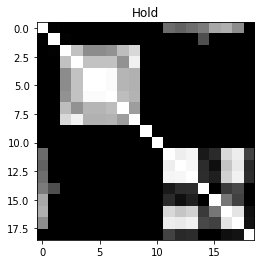

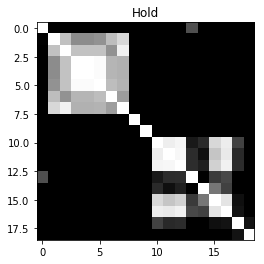

In [11]:
for idx, image in enumerate(images[:2]):
    plt.imshow(image, cmap = "Greys")
    plt.title(label_names[np.int(np.argwhere(image_labels[idx]))])
    plt.show()

# Train - test split without overlap

In [12]:
images_train, images_test, image_labels_train, image_labels_test = train_test_split(images, 
                                                                                    image_labels, 
                                                                                    test_size = .2, 
                                                                                    random_state = 22
                                                                                   )

## We need to get rid of the first (Image Window Size -1) test data to avoid lookahead bias.

In [13]:
images_test = images_test[(Image_window_size-1):]
image_labels_test = image_labels_test[(Image_window_size-1):]

In [14]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (800, 19, 19); Train labels shape : (800, 3)


In [15]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (181, 19, 19); Test labels shape : (181, 3)


# Reshape

In [16]:
images_test = images_test.reshape(-1, images_test.shape[1], images_test.shape[2] , 1)
images_train = images_train.reshape(-1, images_train.shape[1], images_train.shape[2] , 1)

In [17]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (800, 19, 19, 1); Train labels shape : (800, 3)


In [18]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (181, 19, 19, 1); Test labels shape : (181, 3)


# The Deep CNN

## Hyperparameter settings

In [19]:
training_iters = 200
learning_rate = 0.001
batch_size = 128

### Network Parameters

In [20]:
# image shape (d x d)
n_input = images_train.shape[1]

# number of classes
n_classes =  image_labels_train.shape[1]

# dropout
dropout = 0.8 # prob. to keep 

In [21]:
# placeholders float type
#input placeholder
x = tf.placeholder("float", [None, n_input, n_input, 1])

# output placeholder
y = tf.placeholder("float", [None, n_classes])

# dropout
keep_prob = tf.placeholder(tf.float32)

### Wrappers

Because using conv layer multiple times, we define it as a function (strides should be 1 for the first because it is the image number, the last should be one, because the gray scale image is only one channel)

In [22]:
def conv2d(x, W, b, strides = 1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides =[1, strides, strides, 1], padding = 'SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) # activation ReLu

In [23]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [24]:
def avgpool2d(x, k = 2):
    return tf.nn.avg_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

### Initialization of weights, biases

Xavier initialization: Xavier Glorot & Yoshua Bengio (2010), designed to keep the scale of the gradients roughly the same in all layers.

In [25]:
weights = {
    'wc1' : tf.get_variable('W0', shape = (3, 3, 1, 32), initializer=tf.contrib.layers.xavier_initializer()),
    'wc2' : tf.get_variable('W1', shape = (3, 3, 32, 64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape = (3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape = (3*3*128, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('W4', shape = (128, n_classes), initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1' : tf.get_variable('B0', shape = (32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2' : tf.get_variable('B1', shape = (64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3' : tf.get_variable('B2', shape = (128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1' : tf.get_variable('B3', shape = (128), initializer=tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('B4', shape = (n_classes), initializer=tf.contrib.layers.xavier_initializer())
}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


### Network Build

In [26]:
def conv_net(x, weights, biases, dropout):
    # here we call conv2d fct. and pass input image x, weights wc1, bias bc1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a 10*10 matrix (ceil(image_size/2))
    conv1 = avgpool2d(conv1, k = 2) # could be maxpooling
    
    # Convolution layer
    
    # call conv2d, pass input conv1, weights wc2, biases bc2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a ceil(conv1_len/2) * ceil(conv1_len/2)  matrix
    conv2 = avgpool2d(conv2, k = 2)
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a ceil(conv2_len/2)*ceil(conv2_len/2) matrix
    conv3 = avgpool2d(conv3, k = 2)
    
    
    # Fully Connected Layer (Dense)
    # REshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
     # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and bias term for the out
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return out

### Loss and Optimizer Nodes

Loss funciton here is cross entropy, with the reasoning that it's a fitting loss function due to always being positive and tending towards zero if the neuron gets better in guessing the right label and because it recovers faster from wrong intializations and the learning doesnt slow down

Avg. loss over batches to get a  single loss - maybe weighted

In [27]:
pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Evaluate Model Node

U can save a graph and run testing on it later

ACCURACY CAN BE CHANGED TO OTHER MEASURE LATER

In [28]:
# Check wether the index of the maximum value of the predicted image is equal to the actual labelled image - both will be a column vector
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Calculate accuracy across all given images and average them
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
# Initializing the vars
init = tf.global_variables_initializer()

## Training and testing

In [30]:
np.int(np.ceil(len(images_train)/batch_size))

7

In [31]:
for batch in range(np.int(np.ceil(len(images_train)/batch_size))):
            batch_x = images_train[batch*batch_size:min((batch+1)*batch_size, len(images_train))]
            batch_y = image_labels_train[batch*batch_size:min((batch+1)*batch_size, len(image_labels_train))]
            
            print(batch_x.shape, batch_y.shape)

(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(128, 19, 19, 1) (128, 3)
(32, 19, 19, 1) (32, 3)


In [ ]:
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(np.int(np.ceil(len(images_train)/batch_size))):
            batch_x = images_train[batch*batch_size : min((batch+1)*batch_size, len(images_train))]
            batch_y = image_labels_train[batch*batch_size : min((batch+1)*batch_size, len(image_labels_train))]
            
            # Run optimization op (backprop)
            # Calculate batch loss and accuracy
            sess.run(optimizer, feed_dict = {x : batch_x, y : batch_y, keep_prob: dropout})
            
            loss, acc = sess.run([cost, accuracy], feed_dict = {x : batch_x,
                                                                y : batch_y,
                                                                keep_prob: 1.})
        print("Iter " + str(i) + ", Loss = " + \
              "{:.6f}".format(loss) + ", Training Accuracy = " + \
              "{:.5f}".format(acc)
             )
        print('Optimization Finished!')

        # Calculate accuracy for all test images
        test_acc, valid_loss = sess.run([accuracy, cost], feed_dict = {x : images_test,
                                                                       y : image_labels_test,
                                                                       keep_prob: 1.})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print('Testing Accuracy: ', "{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss = 1.082297, Training Accuracy = 0.34375
Optimization Finished!
Testing Accuracy:  0.28177
Iter 1, Loss = 1.103713, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 2, Loss = 1.096647, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 3, Loss = 1.091008, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 4, Loss = 1.091119, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 5, Loss = 1.092422, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 6, Loss = 1.091262, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 7, Loss = 1.091167, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 8, Loss = 1.090894, Training Accuracy = 0.40625
Optimization Finished!
Testing Accuracy:  0.50276
Iter 9, Loss = 1.091208, Training Accuracy = 0.40625
Optimization Finishe

Iter 79, Loss = 1.003558, Training Accuracy = 0.53125
Optimization Finished!
Testing Accuracy:  0.46961
Iter 80, Loss = 0.999136, Training Accuracy = 0.46875
Optimization Finished!
Testing Accuracy:  0.48619
Iter 81, Loss = 0.994671, Training Accuracy = 0.53125
Optimization Finished!
Testing Accuracy:  0.48066
Iter 82, Loss = 0.994050, Training Accuracy = 0.53125
Optimization Finished!
Testing Accuracy:  0.47514
Iter 83, Loss = 0.986476, Training Accuracy = 0.53125
Optimization Finished!
Testing Accuracy:  0.49171
Iter 84, Loss = 0.979382, Training Accuracy = 0.50000
Optimization Finished!
Testing Accuracy:  0.48066
Iter 85, Loss = 0.975697, Training Accuracy = 0.50000
Optimization Finished!
Testing Accuracy:  0.47514
Iter 86, Loss = 0.974671, Training Accuracy = 0.53125
Optimization Finished!
Testing Accuracy:  0.48619
Iter 87, Loss = 0.970445, Training Accuracy = 0.53125
Optimization Finished!
Testing Accuracy:  0.47514
Iter 88, Loss = 0.962643, Training Accuracy = 0.50000
Optimizati

Iter 158, Loss = 0.637625, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.40884
Iter 159, Loss = 0.672533, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.40884
Iter 160, Loss = 0.646249, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.41989
Iter 161, Loss = 0.646163, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.46409
Iter 162, Loss = 0.641787, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.45856
Iter 163, Loss = 0.623227, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.44751
Iter 164, Loss = 0.610325, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.46961
Iter 165, Loss = 0.591820, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.44751
Iter 166, Loss = 0.594964, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy:  0.47514
Iter 167, Loss = 0.591647, Training Accuracy = 0.75000
